# Обучение модели ai-forever/ruRoberta-large для multi-label классификации

In [1]:
!pip install pandas scikit-learn transformers optuna scikit-multilearn openpyxl matplotlib -q 

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import optuna
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_recall_curve, roc_curve, auc, classification_report
from skmultilearn.model_selection import iterative_train_test_split
import joblib
import transformers
import random
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from torch.utils.data import Dataset
import json
import math
import gc
import os
import logging
import builtins

# Проверка версий библиотек
print("transformers version:", transformers.__version__)
print("NumPy version:", np.__version__)
print("Optuna version:", optuna.__version__)
print("Matplotlib version:", matplotlib.__version__)  


transformers version: 4.51.3
NumPy version: 1.23.5
Optuna version: 4.3.0
Matplotlib version: 3.10.1


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [3]:
# Настройка логгирования

logging.basicConfig(
    filename='../reports/logs/cointegrated--rubert-tiny2.log',  # Имя файла для логов
    filemode='w',          # 'w' — перезаписывать, 'a' — дописывать
    level=logging.DEBUG,  # пишутся все уровни логирования: DEBUG, INFO, WARNING, ERROR, CRITICAL
    format='%(asctime)s - %(levelname)s - %(message)s',  # Формат сообщения
)

# --- Свой метод print ---
def print_and_log(*args, level=logging.INFO, **kwargs):
    message = ' '.join(str(arg) for arg in args)
    builtins.print(message, **kwargs)  # Обычный вывод в консоль
    logging.log(level, message)         # И логирование в файл

# --- Переопределение стандартного print ---
print = print_and_log

In [4]:
# Загрузка датасета
data_path = "../data/processed/final.xlsx"
df = pd.read_excel(data_path)

# Посмотрим на первые строки и общую информацию
print("Размер датасета:", df.shape)
df.head(5)


Размер датасета: (4984, 9)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Определяем список тематик (берем из колонок кроме full_text)
all_columns = list(df.columns)
label_cols = [col for col in all_columns if col not in ('full_text', 'Unnamed: 0')]
print("Колонки тем:", label_cols)
num_topics = len(label_cols)
print("Количество тем:", num_topics)


Колонки тем: ['Спорт', 'Личная жизнь', 'Юмор', 'Соцсети', 'Политика', 'Реклама', 'Нет категории']
Количество тем: 7


In [6]:
# Преобразуем вероятности в 0/1 при пороге 0.5
threshold = 0.5
df_labels = (df[label_cols] >= threshold).astype(int)

# Добавим бинарные метки к таблице (для ясности, необязательно)
for col in label_cols:
    df[f"{col}_label"] = df_labels[col]

# Посмотрим фрагмент обновленных данных
df.head(5)


,Unnamed: 0,full_text,Спорт,Личная жизнь,Юмор,Соцсети,Политика,Реклама,Нет категории,Спорт_label,Личная жизнь_label,Юмор_label,Соцсети_label,Политика_label,Реклама_label,Нет категории_label
0,614,лебединая песня… (с подтекстом) 2024 год - го...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
1,789,ура конкурс!!!!!!! одарим же!!! всех любимых ...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,1,0
2,628,"славянский зодиак для познания себе, если еще...",0.0,0.0,0.0,0.5,0.0,0.5,0.0,0,0,0,1,0,1,0
3,531,английским газетам тяжело даётся ожидание фина...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,347,"итак, самое главное:) по фактам! по минутам, с...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [7]:
# Количество текстов, содержащих каждую тему (частота меток)
label_counts = df_labels.sum()
print("Число текстов по темам:")
print(label_counts)

# Среднее и распределение числа тем на текст
labels_per_text = df_labels.sum(axis=1)
print("\nРаспределение числа меток на текст:")
print(labels_per_text.value_counts(), "\nСреднее:", labels_per_text.mean())


Число текстов по темам:
Спорт            1590
Личная жизнь      743
Юмор              892
Соцсети          1345
Политика          573
Реклама           571
Нет категории     593
dtype: int64

Распределение числа меток на текст:
1    3611
2    1348
0      25
Name: count, dtype: int64 
Среднее: 1.2654494382022472


In [8]:
# Преобразуем данные для разделения
X = df['full_text'].values.reshape(-1, 1)   
Y = df_labels.values                        

# Выполняем стратифицированное разделение на train/val
test_size = 0.2
X_train, y_train, X_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)

# Преобразуем обратно в списки/таблицы
train_texts = X_train.ravel()   # превращаем (n,1) обратно в (n,)
val_texts = X_val.ravel()
train_labels = y_train
val_labels = y_val

print(f"Обучающая выборка: {len(train_texts)} текстов")
print(f"Валидационная выборка: {len(val_texts)} текстов")


Обучающая выборка: 3987 текстов
Валидационная выборка: 997 текстов


In [9]:
train_label_freq = train_labels.mean(axis=0)
val_label_freq = val_labels.mean(axis=0)
freq_df = pd.DataFrame({'train_frac': train_label_freq, 'val_frac': val_label_freq}, index=label_cols)
print("Доля положительных примеров по темам в выборках:")
print(freq_df)


Доля положительных примеров по темам в выборках:
               train_frac  val_frac
Спорт            0.319037  0.318957
Личная жизнь     0.148984  0.149448
Юмор             0.179082  0.178536
Соцсети          0.269877  0.269809
Политика         0.114873  0.115346
Реклама          0.114623  0.114343
Нет категории    0.118886  0.119358


In [10]:
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [11]:
num_labels = num_topics  # количество тем
# Создаем сопоставление индексов и названий тем
id2label = {i: label for i, label in enumerate(label_cols)}
label2id = {label: i for i, label in id2label.items()}

# Загружаем модель для классификации
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
print("Модель загружена. Число классов:", model.config.num_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена. Число классов: 7


In [12]:
print("torch version:", torch.__version__)
print("CUDA доступна:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя устройства:", torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Вычислительное устройство:", device)
!nvidia-smi

torch version: 2.5.1
CUDA доступна: True
Имя устройства: NVIDIA GeForce RTX 3080 Ti
Вычислительное устройство: cuda
Sun Apr 27 18:35:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     Off |   00000000:01:00.0 Off |                  N/A |
| 32%   44C    P2             26W /  400W |    9522MiB /  12288MiB |      0%      Default |
|                       

In [13]:
# Токенизация текстов
train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128)
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128)

# Проверим пример токенизации
print(train_texts[0])
print(train_encodings['input_ids'][0][:20], "...", "длина:", len(train_encodings['input_ids'][0]))


лебединая песня… (с подтекстом)  2024 год - год лебедя по зороастрийскому (некоторые считают его арийским) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32-летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя — священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20-21-23 марта. зороастрийский новый год носит название навруз (новруз, ноурыз…) (в переводе с персидского «новый день»). если вы родились 5 января 1976 года, то смотрите себя 1975 годом. так как год в этом летоисчислении начинается весной. для информации: «наступающий 2024 год пройдет под управлением грациозного, элегантного лебедя. этот год будет связан с духовным объединением людей. пришло время подняться над материальным миром, воспарить! пора понять, что не хлебом единым жив человек. и еще, верность семье будет самым главным достоинством в глазах тотема. если вы обладаете этим даром 

In [14]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.astype(np.float32)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Некоторые токенизаторы не выдают token_type_ids для моделей типа RoBERTa, поэтому проверим
        if 'token_type_ids' in item and item['token_type_ids'].ndim == 1:
            # Делаем token_type_ids того же измерения, что и input_ids
            item['token_type_ids'] = item['token_type_ids'].unsqueeze(0)
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Создаем объекты Dataset
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

print("Пример батча:")
for i in range(2):
    example = train_dataset[i]
    print(tokenizer.decode(example['input_ids']), "-- метки:", example['labels'].numpy())


Пример батча:
[CLS] лебединая песня [UNK] ( с подтекстом ) 2024 год - год лебедя по зороастрийскому ( некоторые считают его арийским ) календарю. тотемный гороскоп от предков человечества нам достался в наследство 32 - летний календарь. уникальность тотемного календаря заключается в том, что каждый год в нем имеет своего управителя [UNK] священное животное, тотем. тотемный календарь начинает действовать вдень весеннего равноденствия - 20 - 21 - 23 марта. зороастрийский новый год носит название навруз ( новруз, ноурыз [UNK] ) ( в переводе с персидского « новый день » ) [SEP] -- метки: [0. 0. 0. 0. 0. 1. 0.]
[CLS] славянский зодиак для познания себе, если еще мозг не закипел, ознакомьтесь с собой по дням и месяцам славянского зодиака. каждому месяцу в году и дате рождения соответствовало определенное животное. считалось, что люди, рожденные в этом месяце, обладали качествами этого животного. тотемы животных влияли на судьбу человека. таких животных 12, хотя есть предположение, что первон

In [15]:
class MyDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        batch = self.tokenizer.pad(features, return_tensors="pt")
        # Убираем token_type_ids
        if "token_type_ids" in batch:
            del batch["token_type_ids"]
        return batch

In [16]:
def objective(trial):
    gc.collect()
    torch.cuda.empty_cache()

    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    #batch_size = trial.suggest_categorical('batch_size', [8, 16])
    batch_size = trial.suggest_categorical('batch_size', [4, 8])
    num_epochs = trial.suggest_int('num_epochs', 3, 6)
    weight_decay = trial.suggest_float('weight_decay', 0.0, 0.1)

    model_trial = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="multi_label_classification",
        id2label=id2label,
        label2id=label2id
    )
    model_trial.to(device)

    args = TrainingArguments(
        output_dir="optuna_trial",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        weight_decay=weight_decay,
        save_strategy="no",
        logging_strategy="no",
        disable_tqdm=True,
        dataloader_pin_memory=True,
        fp16=True,
        seed=SEED,
        report_to="none",  # <-- чтобы Optuna не ломался на логах
    )

    # Добавляем data collator для корректной подачи в BERT
    data_collator = DataCollatorWithPadding(tokenizer, padding="longest", return_tensors="pt")

    trainer = Trainer(
        model=model_trial,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=MyDataCollator(tokenizer),
    )

    trainer.train()

    preds = trainer.predict(val_dataset)
    logits = preds.predictions
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    y_pred = (probs >= 0.5).astype(int)
    y_true = preds.label_ids

    f1_micro = f1_score(y_true, y_pred, average='micro')

    del model_trial
    torch.cuda.empty_cache()
    gc.collect()

    return f1_micro


In [17]:
# Создаем исследование Optuna
study = optuna.create_study(direction='maximize', study_name="Multilabel_Optimization")
# Запускаем поиск 
study.optimize(objective, n_trials=10)

print("Наилучшее значение F1 (micro) на валидации: {:.4f}".format(study.best_value))
print("Лучшие гиперпараметры:", study.best_params)


[I 2025-04-27 18:35:02,791] A new study created in memory with name: Multilabel_Optimization
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if i

{'train_runtime': 28.8897, 'train_samples_per_second': 828.045, 'train_steps_per_second': 103.635, 'train_loss': 0.3729619476583375, 'epoch': 6.0}


[I 2025-04-27 18:35:32,537] Trial 0 finished with value: 0.45876887340301975 and parameters: {'learning_rate': 1.4169129165618276e-05, 'batch_size': 8, 'num_epochs': 6, 'weight_decay': 0.008994169373142414}. Best is trial 0 with value: 0.45876887340301975.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old

{'train_runtime': 23.8617, 'train_samples_per_second': 835.44, 'train_steps_per_second': 104.561, 'train_loss': 0.3489288880495366, 'epoch': 5.0}


[I 2025-04-27 18:35:57,465] Trial 1 finished with value: 0.5576923076923077 and parameters: {'learning_rate': 2.0990701996679086e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.06175094604588869}. Best is trial 1 with value: 0.5576923076923077.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old be

{'train_runtime': 27.3805, 'train_samples_per_second': 436.844, 'train_steps_per_second': 109.238, 'train_loss': 0.3850522514810055, 'epoch': 3.0}


[I 2025-04-27 18:36:25,934] Trial 2 finished with value: 0.43493761140819964 and parameters: {'learning_rate': 1.593185681619464e-05, 'batch_size': 4, 'num_epochs': 3, 'weight_decay': 0.03821882025984616}. Best is trial 1 with value: 0.5576923076923077.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old be

{'train_runtime': 23.6867, 'train_samples_per_second': 841.612, 'train_steps_per_second': 105.333, 'train_loss': 0.33749234308460674, 'epoch': 5.0}


[I 2025-04-27 18:36:50,457] Trial 3 finished with value: 0.579650565262076 and parameters: {'learning_rate': 2.394486012532558e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.03095396663960285}. Best is trial 3 with value: 0.579650565262076.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behav

{'train_runtime': 14.1925, 'train_samples_per_second': 842.771, 'train_steps_per_second': 105.478, 'train_loss': 0.35540914185141115, 'epoch': 3.0}


[I 2025-04-27 18:37:05,521] Trial 4 finished with value: 0.5417118093174431 and parameters: {'learning_rate': 3.5367876827276525e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.097928164986353}. Best is trial 3 with value: 0.579650565262076.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behav

{'train_runtime': 55.0005, 'train_samples_per_second': 434.942, 'train_steps_per_second': 108.763, 'train_loss': 0.27762868276052116, 'epoch': 6.0}


[I 2025-04-27 18:38:01,584] Trial 5 finished with value: 0.6752058554437328 and parameters: {'learning_rate': 2.435689420673733e-05, 'batch_size': 4, 'num_epochs': 6, 'weight_decay': 0.024634020687999414}. Best is trial 5 with value: 0.6752058554437328.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old be

{'train_runtime': 19.1031, 'train_samples_per_second': 834.839, 'train_steps_per_second': 104.486, 'train_loss': 0.3941893185785634, 'epoch': 4.0}


[I 2025-04-27 18:38:21,513] Trial 6 finished with value: 0.4391691394658754 and parameters: {'learning_rate': 1.599484427899014e-05, 'batch_size': 8, 'num_epochs': 4, 'weight_decay': 0.030199166819912228}. Best is trial 5 with value: 0.6752058554437328.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old be

{'train_runtime': 36.7818, 'train_samples_per_second': 433.584, 'train_steps_per_second': 108.423, 'train_loss': 0.401503674842888, 'epoch': 4.0}


[I 2025-04-27 18:38:59,372] Trial 7 finished with value: 0.38485033598045204 and parameters: {'learning_rate': 1.013543963392024e-05, 'batch_size': 4, 'num_epochs': 4, 'weight_decay': 0.07733333772213545}. Best is trial 5 with value: 0.6752058554437328.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old be

{'train_runtime': 14.3188, 'train_samples_per_second': 835.336, 'train_steps_per_second': 104.548, 'train_loss': 0.429794729432824, 'epoch': 3.0}


[I 2025-04-27 18:39:14,516] Trial 8 finished with value: 0.34958834705509817 and parameters: {'learning_rate': 1.4276374275119718e-05, 'batch_size': 8, 'num_epochs': 3, 'weight_decay': 0.014379499747167058}. Best is trial 5 with value: 0.6752058554437328.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old 

{'train_runtime': 23.8713, 'train_samples_per_second': 835.102, 'train_steps_per_second': 104.519, 'train_loss': 0.3483195639325526, 'epoch': 5.0}


[I 2025-04-27 18:39:39,235] Trial 9 finished with value: 0.5452620434092113 and parameters: {'learning_rate': 2.1228760744041194e-05, 'batch_size': 8, 'num_epochs': 5, 'weight_decay': 0.05745165474016313}. Best is trial 5 with value: 0.6752058554437328.


Наилучшее значение F1 (micro) на валидации: 0.6752
Лучшие гиперпараметры: {'learning_rate': 2.435689420673733e-05, 'batch_size': 4, 'num_epochs': 6, 'weight_decay': 0.024634020687999414}


In [18]:
# Сохраняем объект Optuna study в файл
os.makedirs("../configs/cointegrated/rubert-tiny2", exist_ok=True)
joblib.dump(study, "../configs/cointegrated/rubert-tiny2/optuna_study.pkl")

# Сохраняем лучшие гиперпараметры в JSON
best_params = study.best_params
best_params['best_val_microF1'] = study.best_value
with open("../configs/cointegrated/rubert-tiny2/best_hyperparams.json", "w") as f:
    #import json
    json.dump(best_params, f, indent=4)


In [19]:
# Извлекаем лучшие гиперпараметры
best_params = study.best_params
best_batch_size = best_params['batch_size']
best_lr = best_params['learning_rate']
best_epochs = best_params['num_epochs']
best_wd = best_params['weight_decay']

# Инициализируем модель с нуля (предобученные веса)
final_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels, 
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)
final_model.to(device)

# Настраиваем аргументы обучения
training_args = TrainingArguments(
    output_dir="../models/final_model",
    per_device_train_batch_size=best_batch_size,
    per_device_eval_batch_size=best_batch_size,
    learning_rate=best_lr,
    num_train_epochs=best_epochs,
    weight_decay=best_wd,
    logging_steps=50,  # просто чтобы были логи каждые 50 шагов
    save_steps=5000,   # ну или чтобы вообще не сохранять (если нет сохранения по шагам)
    fp16=True,
    seed=SEED,
)

trainer_final = Trainer(
    model=final_model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=MyDataCollator(tokenizer),
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
trainer_final.train()


/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar

Step,Training Loss
50,0.627300
100,0.520000
150,0.475000
200,0.460100
250,0.447600
300,0.457400
350,0.427400
400,0.438800
450,0.429200
500,0.400100


/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar

TrainOutput(global_step=5982, training_loss=0.2783819038068439, metrics={'train_runtime': 61.7442, 'train_samples_per_second': 387.437, 'train_steps_per_second': 96.884, 'total_flos': 44130197150208.0, 'train_loss': 0.2783819038068439, 'epoch': 6.0})

In [21]:
# Сохранение обученной модели и токенизатора
trainer_final.model.save_pretrained("../models/cointegrated/rubert-tiny2/final_model")
tokenizer.save_pretrained("../models/cointegrated/rubert-tiny2/final_model")
print("Модель и токенизатор сохранены в ../models/cointegrated/rubert-tiny2/final_model/")

# Внимание, модели могут занимать много места и хранятся отдельно
# https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link

Модель и токенизатор сохранены в ../models/cointegrated/rubert-tiny2/final_model/


<h1 style="color:red;">Внимание, модели могут занимать много места и хранятся отдельно</h1>

<p><a href="https://drive.google.com/drive/folders/1F62--WR0UaHIkDsE0IpWxGPP7_MWRES_?usp=drive_link" target="_blank">Ссылка на модели (Google Drive)</a></p>

In [22]:
# Предсказание на валидационной выборке
preds = trainer_final.predict(val_dataset)
logits = preds.predictions
probs = torch.sigmoid(torch.tensor(logits)).numpy()
y_true = preds.label_ids
y_pred_05 = (probs >= 0.5).astype(int)


/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/home/vlad/anaconda3/envs/MIFI_Hackaton_Polyglot_News_Analyzer/lib/python3.10/site-packages/transformers/utils/generic.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar

In [23]:
micro_f1 = f1_score(y_true, y_pred_05, average='micro')
macro_f1 = f1_score(y_true, y_pred_05, average='macro')
macro_roc_auc = roc_auc_score(y_true, probs, average='macro')
accuracy = accuracy_score(y_true, y_pred_05)

print(f"Micro F1 = {micro_f1:.3f}")
print(f"Macro F1 = {macro_f1:.3f}")
print(f"Macro ROC-AUC = {macro_roc_auc:.3f}")
print(f"Subset Accuracy = {accuracy:.3f}")


Micro F1 = 0.655
Macro F1 = 0.579
Macro ROC-AUC = 0.890
Subset Accuracy = 0.463


In [24]:
topic_report = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=False,
    zero_division=0
)
print(topic_report)

report_dict = classification_report(
    y_true, 
    y_pred_05, 
    target_names=label_cols, 
    digits=3, 
    output_dict=True,
    zero_division=0)
# Отбираем только «настоящие» классы, исключая accuracy и усреднения
label_keys = [k for k in report_dict if k not in ("samples avg", "micro avg", "macro avg", "weighted avg")]
# Извлекаем support для каждого класса в виде списка
support_list = [report_dict[k]["support"] for k in label_keys]
print("Список поддержек:", support_list)


               precision    recall  f1-score   support

        Спорт      0.929     0.906     0.917       318
 Личная жизнь      0.588     0.268     0.369       149
         Юмор      0.717     0.612     0.661       178
      Соцсети      0.694     0.413     0.517       269
     Политика      0.778     0.791     0.784       115
      Реклама      0.615     0.588     0.601       114
Нет категории      0.700     0.118     0.201       119

    micro avg      0.769     0.571     0.655      1262
    macro avg      0.717     0.528     0.579      1262
 weighted avg      0.745     0.571     0.623      1262
  samples avg      0.669     0.606     0.619      1262

Список поддержек: [318.0, 149.0, 178.0, 269.0, 115.0, 114.0, 119.0]


In [25]:
best_thresholds = {}
best_f1_scores = []
for i, topic in enumerate(label_cols):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], probs[:, i])
    # Вычисляем F1 для каждого порога
    f1_scores = []
    for p, r in zip(precision, recall):
        if p + r == 0:
            f1 = 0
        else:
            f1 = 2 * p * r / (p + r)
        f1_scores.append(f1)
    f1_scores = np.array(f1_scores)
    best_idx = f1_scores[:-1].argmax()  # последний элемент precision/recall не имеет соотв. порога
    best_thr = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    best_f1_scores.append(best_f1)
    best_thresholds[topic] = best_thr
    print(f"Тема '{topic}': лучший порог = {best_thr:.3f}, F1 = {best_f1:.3f}")

def compute_weighted_f1(f1_per_class, support_per_class):
    total = sum(support_per_class)
    weighted_f1 = sum(f1 * support for f1, support in zip(f1_per_class, support_per_class)) / total
    return weighted_f1

weighted_f1 = compute_weighted_f1(best_f1_scores, support_list)
print(f'''
Взвешенный F1: {weighted_f1:.4f}
''')


Тема 'Спорт': лучший порог = 0.347, F1 = 0.927
Тема 'Личная жизнь': лучший порог = 0.264, F1 = 0.506
Тема 'Юмор': лучший порог = 0.538, F1 = 0.671
Тема 'Соцсети': лучший порог = 0.192, F1 = 0.631
Тема 'Политика': лучший порог = 0.553, F1 = 0.807
Тема 'Реклама': лучший порог = 0.575, F1 = 0.643
Тема 'Нет категории': лучший порог = 0.269, F1 = 0.466

Взвешенный F1: 0.6982



In [26]:
# Применяем индивидуальные пороги для каждого класса
y_pred_opt = np.zeros_like(y_pred_05)
for i, topic in enumerate(label_cols):
    thr = best_thresholds[topic]
    y_pred_opt[:, i] = (probs[:, i] >= thr).astype(int)

micro_f1_opt = f1_score(y_true, y_pred_opt, average='micro')
macro_f1_opt = f1_score(y_true, y_pred_opt, average='macro')
accuracy_opt = accuracy_score(y_true, y_pred_opt)
print(f"После калибровки порогов: micro F1 = {micro_f1_opt:.3f}, macro F1 = {macro_f1_opt:.3f}, accuracy = {accuracy_opt:.3f}")


После калибровки порогов: micro F1 = 0.696, macro F1 = 0.665, accuracy = 0.480


In [27]:
# Функция для приведения к сериализуемому виду
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.generic):  # все numpy-скаляры
        return obj.item()
    else:
        return obj

# Подготовка данных
config = {
    "model_name": model_name,
    "best_hyperparams": make_serializable(best_params),
    "thresholds": make_serializable(best_thresholds)
}

# Сохраняем в файл
with open("../configs/cointegrated/rubert-tiny2/final_config.json", "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

print("Конфигурация с гиперпараметрами и порогами сохранена в configs/cointegrated/rubert-tiny2/final_config.json ✅")


Конфигурация с гиперпараметрами и порогами сохранена в configs/cointegrated/rubert-tiny2/final_config.json ✅


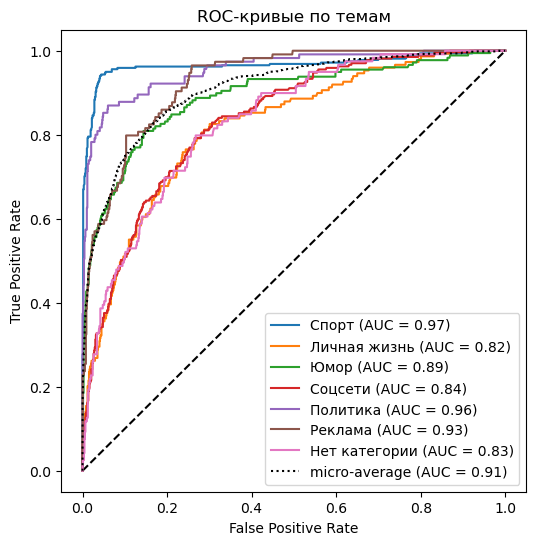

In [28]:
# Вычисляем точки для ROC-кривых
fpr = {}
tpr = {}
roc_auc = {}
for i, topic in enumerate(label_cols):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Микро-усредненная ROC (считаем как если все метки в один длинный список)
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Строим график
plt.figure(figsize=(6, 6))
# Диагональ случайного угадывания
plt.plot([0, 1], [0, 1], 'k--')
# Кривые по темам
for i, topic in enumerate(label_cols):
    plt.plot(fpr[i], tpr[i], label=f"{topic} (AUC = {roc_auc[i]:.2f})")
# Микро усредненная кривая
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.2f})", color='black', linestyle=':')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые по темам")
plt.legend(loc="lower right")
plt.show()


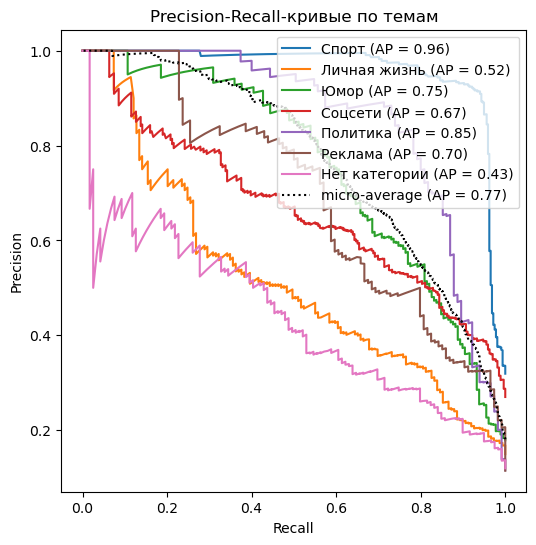

In [29]:
plt.figure(figsize=(6, 6))
for i, topic in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], probs[:, i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{topic} (AP = {pr_auc:.2f})")
# микро-усредненная PR
precision_micro, recall_micro, _ = precision_recall_curve(y_true.ravel(), probs.ravel())
ap_micro = auc(recall_micro, precision_micro)
plt.plot(recall_micro, precision_micro, label=f"micro-average (AP = {ap_micro:.2f})", color='black', linestyle=':')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall-кривые по темам")
plt.legend(loc="upper right")
plt.show()


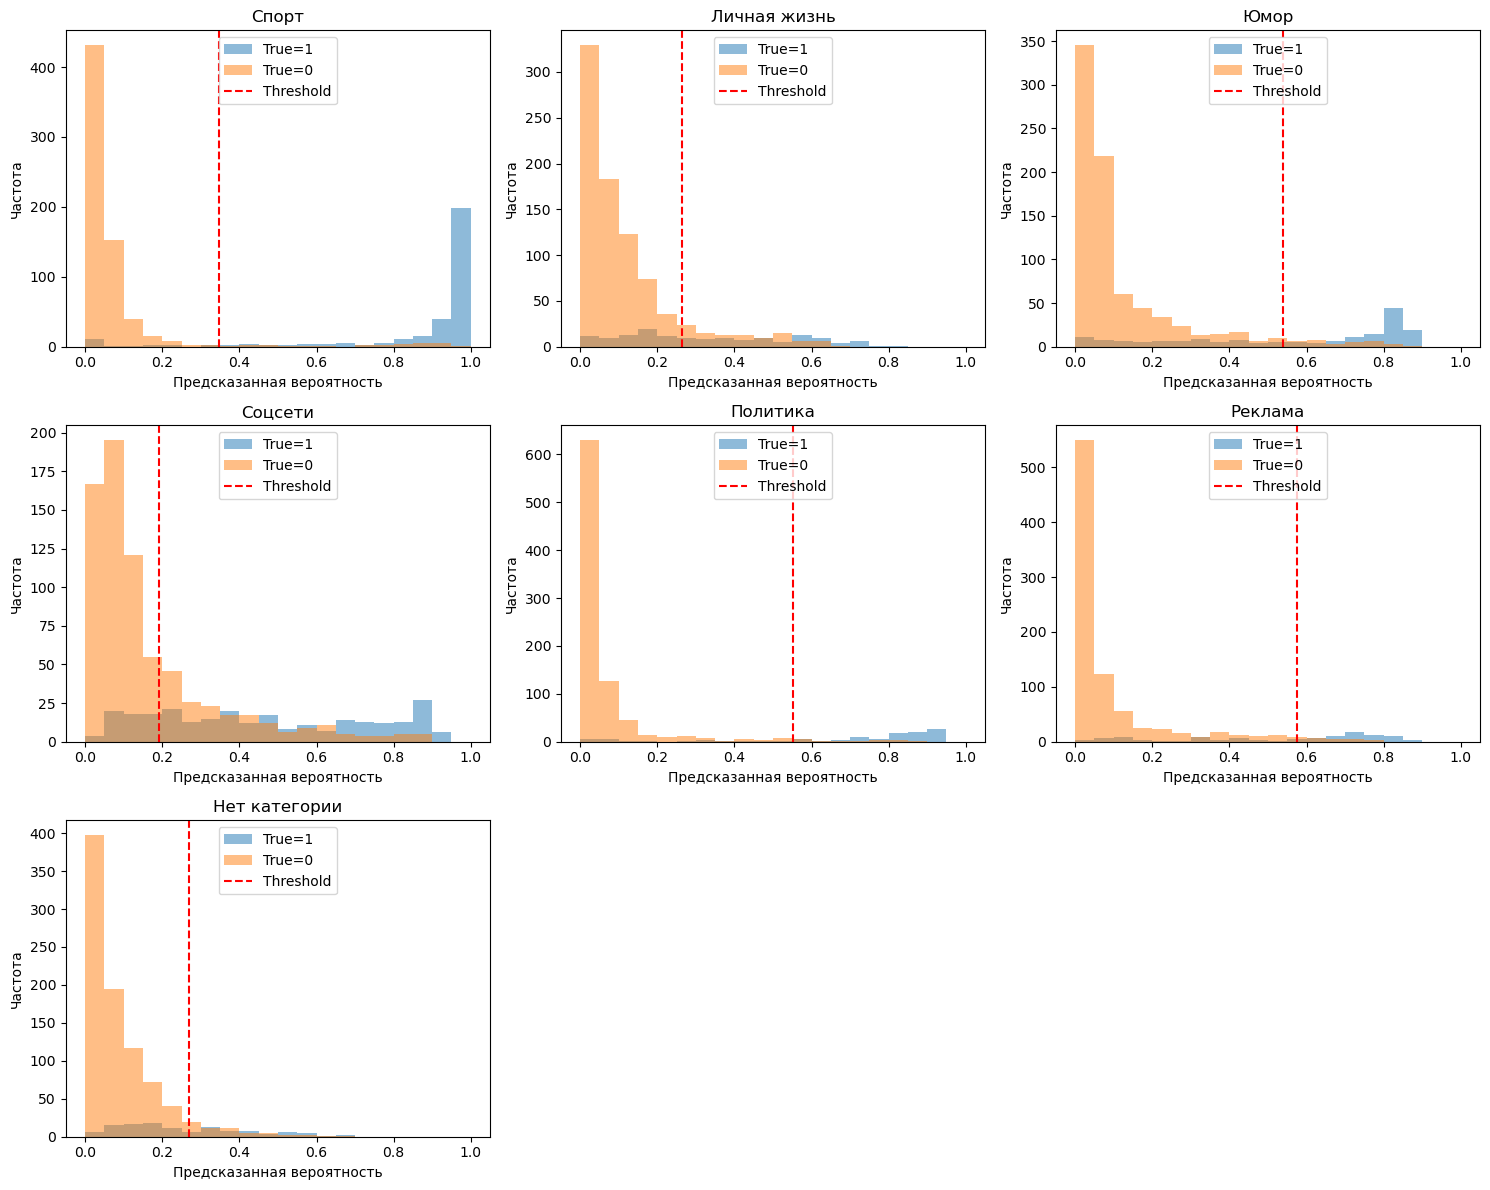

In [30]:
n_labels = len(label_cols)
n_cols = 3
n_rows = math.ceil(n_labels / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(label_cols):
    ax = axes[i]
    pos_probs = probs[y_true[:, i] == 1, i]
    neg_probs = probs[y_true[:, i] == 0, i]
    ax.hist(pos_probs, bins=20, range=(0,1), alpha=0.5, label="True=1")
    ax.hist(neg_probs, bins=20, range=(0,1), alpha=0.5, label="True=0")
    ax.axvline(best_thresholds.get(topic, 0.5), color='red', linestyle='--', label='Threshold')
    ax.set_title(topic)
    ax.set_xlabel("Предсказанная вероятность")
    ax.set_ylabel("Частота")
    ax.legend(loc="upper center")

# Отключим пустые графики если их больше, чем нужно
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

